<a href="https://colab.research.google.com/github/easywater4528/my-ML-project/blob/main/LLM_mentoring1030.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
print("=" * 60)
print("환경 설정 확인")
print("=" * 60)
try:
    import cuml
    CUML_AVAILABLE = True
    print("CUML 사용가능")
except ImportError:
    CUML_AVAILABLE = False
    print("CUML 사용불가능")

환경 설정 확인
CUML 사용가능


In [4]:
def generate_dataset(n_samples, n_features, task='classification'):
    """대규모 데이터셋 생성"""
    print(f"데이터셋 생성 중: {n_samples:,}개 샘플, {n_features}개 특징")

    if task == 'classification':
        X, y = make_classification(
            n_samples=n_samples,
            n_features=n_features,
            n_informative=n_features // 2,
            n_redundant=n_features // 4,
            random_state=42
        )
    else:
        X, y = make_regression(
            n_samples=n_samples,
            n_features=n_features,
            n_informative=n_features // 2,
            random_state=42
        )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test


In [11]:
def benchmark_random_forest(X_train, X_test, y_train, y_test):
    """랜덤 포레스트 비교"""
    print("\n" + "="*60)
    print("2. 랜덤 포레스트 벤치마크")
    print("="*60)

    results = {}
    n_estimators = 100

    # scikit-learn (CPU)
    from sklearn.ensemble import RandomForestClassifier
    print(f"\n[CPU] scikit-learn RandomForest ({n_estimators} trees) 학습 중...")

    start = time.time()
    rf_cpu = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=10,
        random_state=42,
        n_jobs=-1  # 모든 CPU 코어 사용
    )
    rf_cpu.fit(X_train, y_train)
    train_time = time.time() - start

    start = time.time()
    score_cpu = rf_cpu.score(X_test, y_test)
    pred_time = time.time() - start

    results['CPU'] = {'train': train_time, 'predict': pred_time, 'accuracy': score_cpu}
    print(f"   학습 시간: {train_time:.4f}초")
    print(f"   예측 시간: {pred_time:.4f}초")
    print(f"   정확도: {score_cpu:.4f}")

    # cuML (GPU)
    if CUML_AVAILABLE:
        from cuml.ensemble import RandomForestClassifier as cuRF
        import cudf

        print(f"\n[GPU] cuML RandomForest ({n_estimators} trees) 학습 중...")

        X_train_gpu = cudf.DataFrame(X_train)
        y_train_gpu = cudf.Series(y_train)
        X_test_gpu = cudf.DataFrame(X_test)
        y_test_gpu = cudf.Series(y_test)

        start = time.time()
        rf_gpu = cuRF(
            n_estimators=n_estimators,
            max_depth=10,
            random_state=42
        )
        rf_gpu.fit(X_train_gpu, y_train_gpu)
        train_time = time.time() - start

        start = time.time()
        score_gpu = rf_gpu.score(X_test_gpu, y_test_gpu)
        pred_time = time.time() - start

        results['GPU'] = {'train': train_time, 'predict': pred_time, 'accuracy': score_gpu}
        print(f"   학습 시간: {train_time:.4f}초")
        print(f"   예측 시간: {pred_time:.4f}초")
        print(f"   정확도: {score_gpu:.4f}")

        speedup = results['CPU']['train'] / results['GPU']['train']
        print(f"\n   🚀 GPU 속도 향상: {speedup:.2f}x")

    return results

In [9]:
def benchmark_logistic_regression(X_train, X_test, y_train, y_test):
    """로지스틱 회귀 / SGD 비교"""
    print("\n" + "="*60)
    print("1. 로지스틱 회귀 (SGD) 벤치마크")
    print("="*60)

    results = {}

    # scikit-learn (CPU)
    from sklearn.linear_model import SGDClassifier
    print("\n[CPU] scikit-learn SGDClassifier 학습 중...")

    start = time.time()
    clf_cpu = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
    clf_cpu.fit(X_train, y_train)
    train_time = time.time() - start

    start = time.time()
    score_cpu = clf_cpu.score(X_test, y_test)
    pred_time = time.time() - start

    results['CPU'] = {'train': train_time, 'predict': pred_time, 'accuracy': score_cpu}
    print(f"   학습 시간: {train_time:.4f}초")
    print(f"   예측 시간: {pred_time:.4f}초")
    print(f"   정확도: {score_cpu:.4f}")

    # cuML (GPU)
    if CUML_AVAILABLE:
        try:
            from cuml.linear_model import LogisticRegression as cuLR
            import cudf

            print("\n[GPU] cuML LogisticRegression 학습 중...")

            # GPU 메모리로 데이터 전송
            X_train_gpu = cudf.DataFrame(X_train)
            y_train_gpu = cudf.Series(y_train)
            X_test_gpu = cudf.DataFrame(X_test)
            y_test_gpu = cudf.Series(y_test)

            start = time.time()
            clf_gpu = cuLR(max_iter=1000, tol=1e-3)
            clf_gpu.fit(X_train_gpu, y_train_gpu)
            train_time = time.time() - start

            start = time.time()
            score_gpu = clf_gpu.score(X_test_gpu, y_test_gpu)
            pred_time = time.time() - start

            results['GPU'] = {'train': train_time, 'predict': pred_time, 'accuracy': score_gpu}
            print(f"   학습 시간: {train_time:.4f}초")
            print(f"   예측 시간: {pred_time:.4f}초")
            print(f"   정확도: {score_gpu:.4f}")

            speedup = results['CPU']['train'] / results['GPU']['train']
            print(f"\n   🚀 GPU 속도 향상: {speedup:.2f}x")
        except Exception as e:
            print(f"\n[GPU] cuML 실행 실패: {e}")
            print("   scikit-learn 결과만 사용합니다.")

    return results

In [10]:
def benchmark_kmeans(X_train, n_clusters=10):
    """K-Means 클러스터링 비교"""
    print("\n" + "="*60)
    print("4. K-Means 클러스터링 벤치마크")
    print("="*60)

    results = {}

    # scikit-learn (CPU)
    from sklearn.cluster import KMeans
    print(f"\n[CPU] scikit-learn K-Means (k={n_clusters}) 학습 중...")

    start = time.time()
    kmeans_cpu = KMeans(n_clusters=n_clusters, random_state=42, max_iter=300)
    kmeans_cpu.fit(X_train)
    train_time = time.time() - start

    results['CPU'] = {'train': train_time}
    print(f"   학습 시간: {train_time:.4f}초")
    print(f"   Inertia: {kmeans_cpu.inertia_:.2f}")

    # cuML (GPU)
    if CUML_AVAILABLE:
        from cuml.cluster import KMeans as cuKMeans
        import cudf

        print(f"\n[GPU] cuML K-Means (k={n_clusters}) 학습 중...")

        X_train_gpu = cudf.DataFrame(X_train)

        start = time.time()
        kmeans_gpu = cuKMeans(n_clusters=n_clusters, random_state=42, max_iter=300)
        kmeans_gpu.fit(X_train_gpu)
        train_time = time.time() - start

        results['GPU'] = {'train': train_time}
        print(f"   학습 시간: {train_time:.4f}초")
        print(f"   Inertia: {kmeans_gpu.inertia_:.2f}")

        speedup = results['CPU']['train'] / results['GPU']['train']
        print(f"\n   🚀 GPU 속도 향상: {speedup:.2f}x")

    return results

In [12]:
def plot_comparison(all_results):
    """결과 시각화"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('전통적인 머신러닝: CPU vs GPU 성능 비교', fontsize=16, fontweight='bold')

    algorithms = ['로지스틱 회귀', '랜덤 포레스트','K-Means']

    for idx, (ax, (name, results)) in enumerate(zip(axes.flat, zip(algorithms, all_results))):
        if not results:
            ax.text(0.5, 0.5, '데이터 없음', ha='center', va='center')
            ax.set_title(name)
            continue

        devices = list(results.keys())
        train_times = [results[d].get('train', 0) for d in devices]

        bars = ax.bar(devices, train_times, alpha=0.7, color=['#3498db', '#e74c3c'])
        ax.set_ylabel('학습 시간 (초)', fontsize=11)
        ax.set_title(name, fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)

        # 값 표시
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}s',
                   ha='center', va='bottom', fontsize=10)

        # 속도 향상 표시
        if len(devices) == 2 and train_times[1] > 0:
            speedup = train_times[0] / train_times[1]
            ax.text(0.5, 0.95, f'GPU {speedup:.2f}x 빠름',
                   transform=ax.transAxes,
                   ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                   fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()


🔬 전통적인 머신러닝: CPU vs GPU 비교 시작

데이터셋 크기: 100,000 샘플 x 50 특징
데이터셋 생성 중: 100,000개 샘플, 50개 특징

1. 로지스틱 회귀 (SGD) 벤치마크

[CPU] scikit-learn SGDClassifier 학습 중...
   학습 시간: 5.6779초
   예측 시간: 0.0039초
   정확도: 0.7308

[GPU] cuML LogisticRegression 학습 중...
   학습 시간: 2.1874초
   예측 시간: 1.2059초
   정확도: 0.7625

   🚀 GPU 속도 향상: 2.60x

2. 랜덤 포레스트 벤치마크

[CPU] scikit-learn RandomForest (100 trees) 학습 중...
   학습 시간: 49.4764초
   예측 시간: 0.1529초
   정확도: 0.9223

[GPU] cuML RandomForest (100 trees) 학습 중...
   학습 시간: 2.2727초
   예측 시간: 0.9653초
   정확도: 0.9204

   🚀 GPU 속도 향상: 21.77x

4. K-Means 클러스터링 벤치마크

[CPU] scikit-learn K-Means (k=10) 학습 중...
   학습 시간: 0.5747초
   Inertia: 66313545.65

[GPU] cuML K-Means (k=10) 학습 중...
   학습 시간: 1.8191초
   Inertia: 66235395.26

   🚀 GPU 속도 향상: 0.32x

📊 결과 시각화 중...


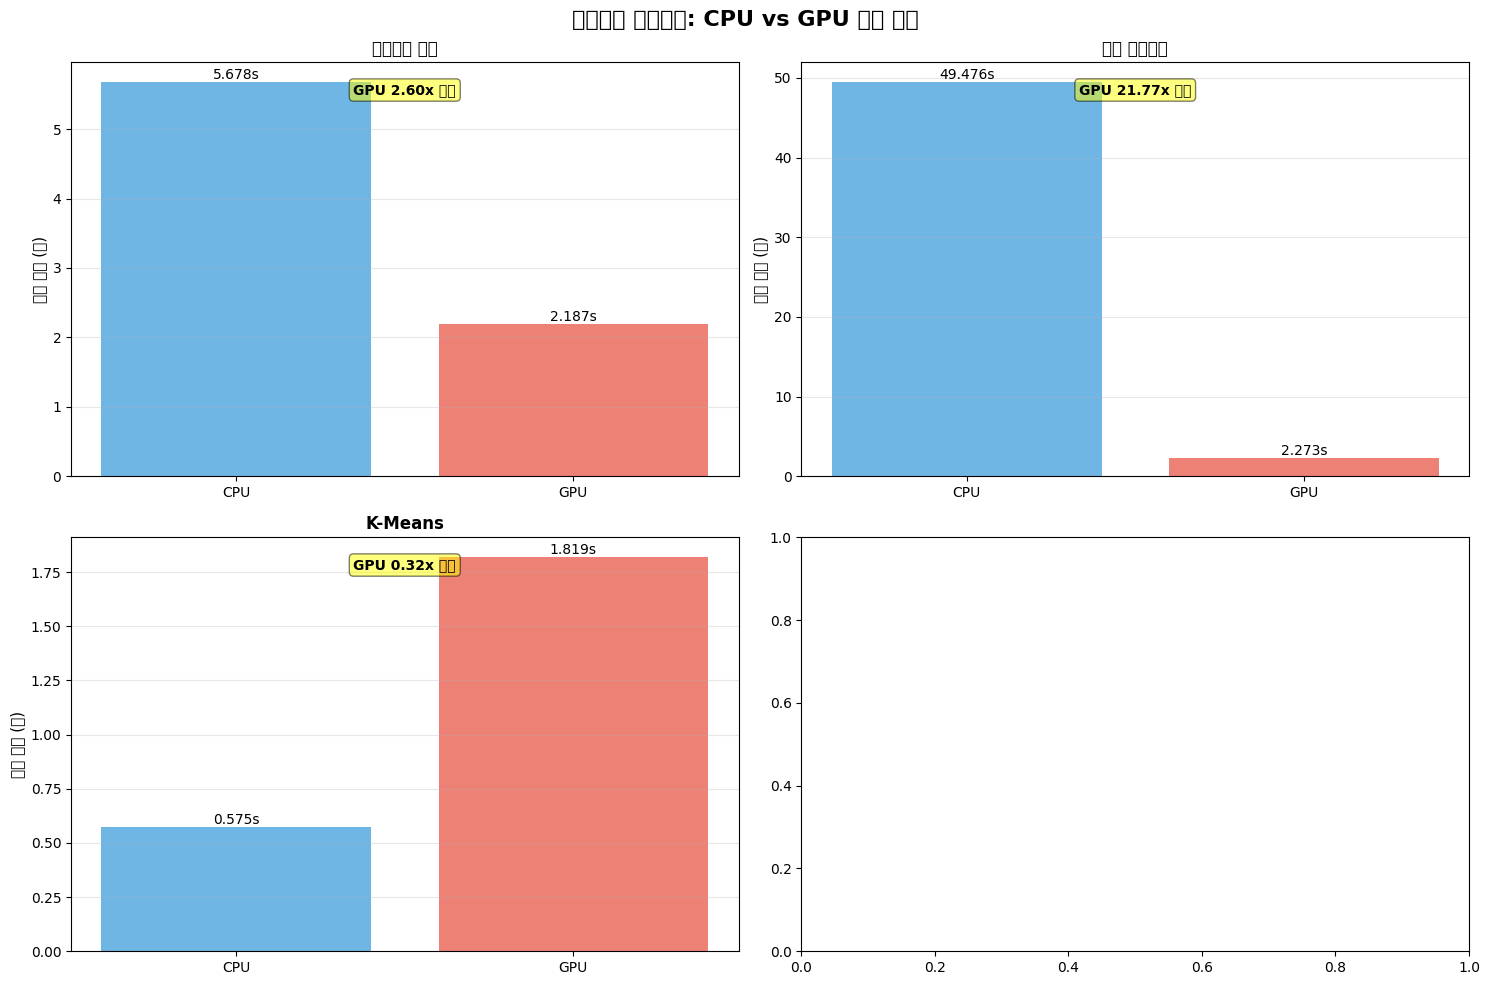

In [13]:
if __name__ == "__main__":
    print("\n🔬 전통적인 머신러닝: CPU vs GPU 비교 시작\n")

    # 데이터셋 크기 설정
    n_samples = 100000  # 10만 개 샘플
    n_features = 50     # 50개 특징

    print("=" * 60)
    print(f"데이터셋 크기: {n_samples:,} 샘플 x {n_features} 특징")
    print("=" * 60)

    # 분류 데이터셋 생성
    X_train, X_test, y_train, y_test = generate_dataset(n_samples, n_features, 'classification')

    all_results = []

    # 1. 로지스틱 회귀 (SGD)
    lr_results = benchmark_logistic_regression(X_train, X_test, y_train, y_test)
    all_results.append(lr_results)

    # 2. 랜덤 포레스트
    rf_results = benchmark_random_forest(X_train, X_test, y_train, y_test)
    all_results.append(rf_results)


    # 4. K-Means
    kmeans_results = benchmark_kmeans(X_train, n_clusters=10)
    all_results.append(kmeans_results)

    # 결과 시각화
    print("\n📊 결과 시각화 중...")
    plot_comparison(all_results)


    if not CUML_AVAILABLE:
        print("\n⚠️  cuML 설치하기:")
        print("   !pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com")
        print("   (Colab에서 GPU 런타임 필요)")